## Import Modules

In [1]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import random
from tqdm.notebook import tqdm
warnings.filterwarnings('ignore')
%matplotlib inline
from tensorflow.keras.preprocessing.image import load_img
import tensorflow as tf
from tensorflow.keras.utils import to_categorical
from keras.models import Sequential
from keras.layers import Dense, Conv2D, Dropout, Flatten, MaxPooling2D
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Dropout, Flatten, Dense
from tensorflow.keras.preprocessing.image import load_img
import numpy as np
from tqdm import tqdm
from tensorflow.keras.utils import to_categorical
import numpy as np
from sklearn.preprocessing import LabelEncoder

## Load the Dataset

In [2]:
TRAIN_DIR = 'C:/Emotion Detection/fer2013plus/fer2013/train/'
TEST_DIR = 'C:/Emotion Detection/fer2013plus/fer2013/test/'


In [3]:
def load_dataset(directory):
    image_paths = []
    labels = []
    
    for label in os.listdir(directory):
        for filename in os.listdir(directory+label):
            image_path = os.path.join(directory, label, filename)
            image_paths.append(image_path)
            labels.append(label)
            
        print(label, "Completed")
        
    return image_paths, labels

In [4]:
## convert into dataframe
train = pd.DataFrame()
train['image'], train['label'] = load_dataset(TRAIN_DIR)
# shuffle the dataset
train = train.sample(frac=1).reset_index(drop=True)
train.head()

anger Completed
contempt Completed
disgust Completed
fear Completed
happiness Completed
neutral Completed
sadness Completed
surprise Completed


,image,label
0,C:/Emotion Detection/fer2013plus/fer2013/train...,neutral
1,C:/Emotion Detection/fer2013plus/fer2013/train...,neutral
2,C:/Emotion Detection/fer2013plus/fer2013/train...,neutral
3,C:/Emotion Detection/fer2013plus/fer2013/train...,neutral
4,C:/Emotion Detection/fer2013plus/fer2013/train...,surprise


In [5]:
test = pd.DataFrame()
test['image'], test['label'] = load_dataset(TEST_DIR)
test.head()

anger Completed
contempt Completed
disgust Completed
fear Completed
happiness Completed
neutral Completed
sadness Completed
surprise Completed


,image,label
0,C:/Emotion Detection/fer2013plus/fer2013/test/...,anger
1,C:/Emotion Detection/fer2013plus/fer2013/test/...,anger
2,C:/Emotion Detection/fer2013plus/fer2013/test/...,anger
3,C:/Emotion Detection/fer2013plus/fer2013/test/...,anger
4,C:/Emotion Detection/fer2013plus/fer2013/test/...,anger


## Exploratory Data Analysis

In [25]:
sns.countplot(train['label'])

<Axes: xlabel='count', ylabel='label'>

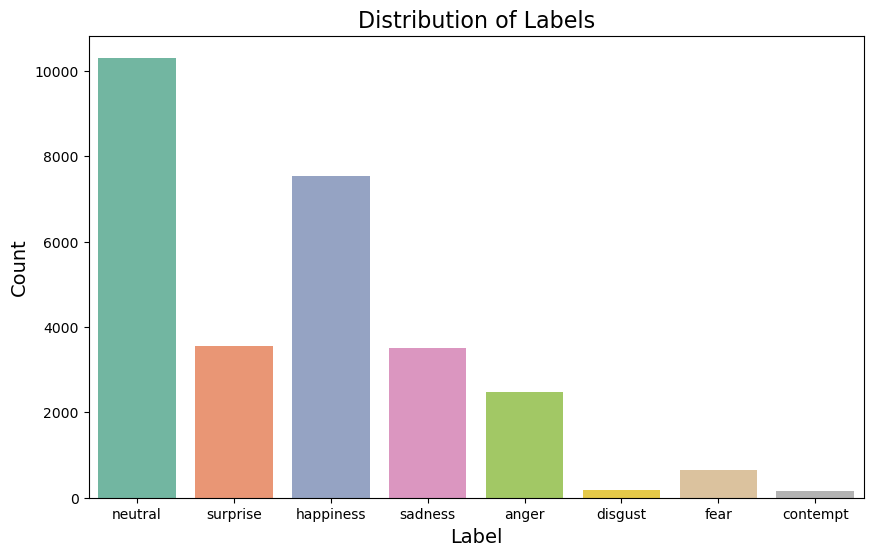

In [27]:
import seaborn as sns
import matplotlib.pyplot as plt

# Plot the count of labels using Seaborn
plt.figure(figsize=(10, 6))  # Set the figure size
sns.countplot(x=train['label'], palette='Set2')  # Use a pleasant color palette

# Add labels and title
plt.title('Distribution of Labels', fontsize=16)
plt.xlabel('Label', fontsize=14)
plt.ylabel('Count', fontsize=14)

# Display the plot
plt.show()


In [7]:
from PIL import Image
img = Image.open(train['image'][0])
plt.imshow(img, cmap='gray');

In [8]:
# to display grid of images
plt.figure(figsize=(20,20))
files = train.iloc[0:25]

for index, file, label in files.itertuples():
    plt.subplot(5, 5, index+1)
    img = load_img(file)
    img = np.array(img)
    plt.imshow(img)
    plt.title(label)
    plt.axis('off')

## Feature Extraction

In [9]:
def extract_features(images):
    features = []
    for image in tqdm(images):
        # Update: Use color_mode instead of grayscale
        img = load_img(image, color_mode='grayscale')
        img = np.array(img)
        features.append(img)
    features = np.array(features)
    features = features.reshape(len(features), 48, 48, 1)  # Assuming the image size is 48x48
    return features

# Assuming train['image'] contains file paths to images
train_features = extract_features(train['image'])


100%|███████████████████████████████████████████████████████████████████████████| 28386/28386 [00:28<00:00, 986.39it/s]


In [10]:
train_features = extract_features(train['image'])

100%|██████████████████████████████████████████████████████████████████████████| 28386/28386 [00:15<00:00, 1782.11it/s]


In [11]:
test_features = extract_features(test['image'])

100%|████████████████████████████████████████████████████████████████████████████| 7099/7099 [00:06<00:00, 1047.36it/s]


In [12]:
## normalize the image
x_train = train_features/255.0
x_test = test_features/255.0

In [13]:
## convert label to integer
le = LabelEncoder()
le.fit(train['label'])
y_train = le.transform(train['label'])
y_test = le.transform(test['label'])

In [14]:
print(np.unique(y_train))
print(np.unique(y_test))


# Dynamically determine the number of classes
num_classes = len(np.unique(y_train))  # This will be 8 based on your dataset
print(f"Number of classes: {num_classes}")

# Convert labels to one-hot encoding
y_train = to_categorical(y_train, num_classes=num_classes)
y_test = to_categorical(y_test, num_classes=num_classes)

print("Labels successfully one-hot encoded!")


[0 1 2 3 4 5 6 7]
[0 1 2 3 4 5 6 7]
Number of classes: 8
Labels successfully one-hot encoded!


In [15]:
y_train[0]

array([0., 0., 0., 0., 0., 1., 0., 0.])

In [16]:
# config
input_shape = (48, 48, 1)
output_class = 8

## Model Creation

In [17]:

# Define the model
model = Sequential()

# Convolutional layers
model.add(Conv2D(128, kernel_size=(3, 3), activation='relu', input_shape=input_shape))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(256, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

model.add(Conv2D(512, kernel_size=(3, 3), activation='relu'))
model.add(MaxPooling2D(pool_size=(2, 2)))
model.add(Dropout(0.4))

# Flatten layer
model.add(Flatten())

# Fully connected layers
model.add(Dense(512, activation='relu'))
model.add(Dropout(0.4))
model.add(Dense(256, activation='relu'))
model.add(Dropout(0.3))

# Output layer
model.add(Dense(output_class, activation='softmax'))

# Compile the model
model.compile(optimizer='adam', 
              loss='categorical_crossentropy', 
              metrics=['accuracy'])  # Use a list for metrics

print("Model compiled successfully!")


Model compiled successfully!


In [18]:
# train the model
history = model.fit(x=x_train, y=y_train, batch_size=128, epochs=10, validation_data=(x_test, y_test))

Epoch 1/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 223s 991ms/step - accuracy: 0.3390 - loss: 1.6679 - val_accuracy: 0.3651 - val_loss: 1.6033
Epoch 2/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 380s 2s/step - accuracy: 0.3643 - loss: 1.5749 - val_accuracy: 0.4327 - val_loss: 1.4509
Epoch 3/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 397s 2s/step - accuracy: 0.4371 - loss: 1.4451 - val_accuracy: 0.5815 - val_loss: 1.1737
Epoch 4/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 392s 2s/step - accuracy: 0.5798 - loss: 1.2056 - val_accuracy: 0.6274 - val_loss: 1.0490
Epoch 5/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 384s 2s/step - accuracy: 0.6218 - loss: 1.0908 - val_accuracy: 0.6738 - val_loss: 0.9402
Epoch 6/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 377s 2s/step - accuracy: 0.6434 - loss: 1.0120 - val_accuracy: 0.6947 - val_loss: 0.8799
Epoch 7/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.6658 - loss: 0.9613 - val_accuracy: 0.6945 - val_loss: 0.8706
Epoch 8/10
222/222 ━━━━━━━━━━━━━━━━━━━━ 383s 2s/step - accuracy: 0.6699 - loss: 0.9291 - val_a

## Plot the Results

Final Test Accuracy: 0.7283

Epoch-wise Training and Validation Accuracy:
Epoch 1: Training Accuracy = 0.3529, Validation Accuracy = 0.3651
Epoch 2: Training Accuracy = 0.3890, Validation Accuracy = 0.4327
Epoch 3: Training Accuracy = 0.4800, Validation Accuracy = 0.5815
Epoch 4: Training Accuracy = 0.5909, Validation Accuracy = 0.6274
Epoch 5: Training Accuracy = 0.6241, Validation Accuracy = 0.6738
Epoch 6: Training Accuracy = 0.6454, Validation Accuracy = 0.6947
Epoch 7: Training Accuracy = 0.6638, Validation Accuracy = 0.6945
Epoch 8: Training Accuracy = 0.6772, Validation Accuracy = 0.7095
Epoch 9: Training Accuracy = 0.6859, Validation Accuracy = 0.7187
Epoch 10: Training Accuracy = 0.6910, Validation Accuracy = 0.7283


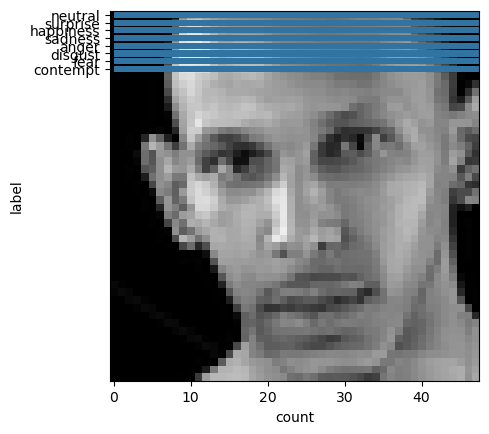

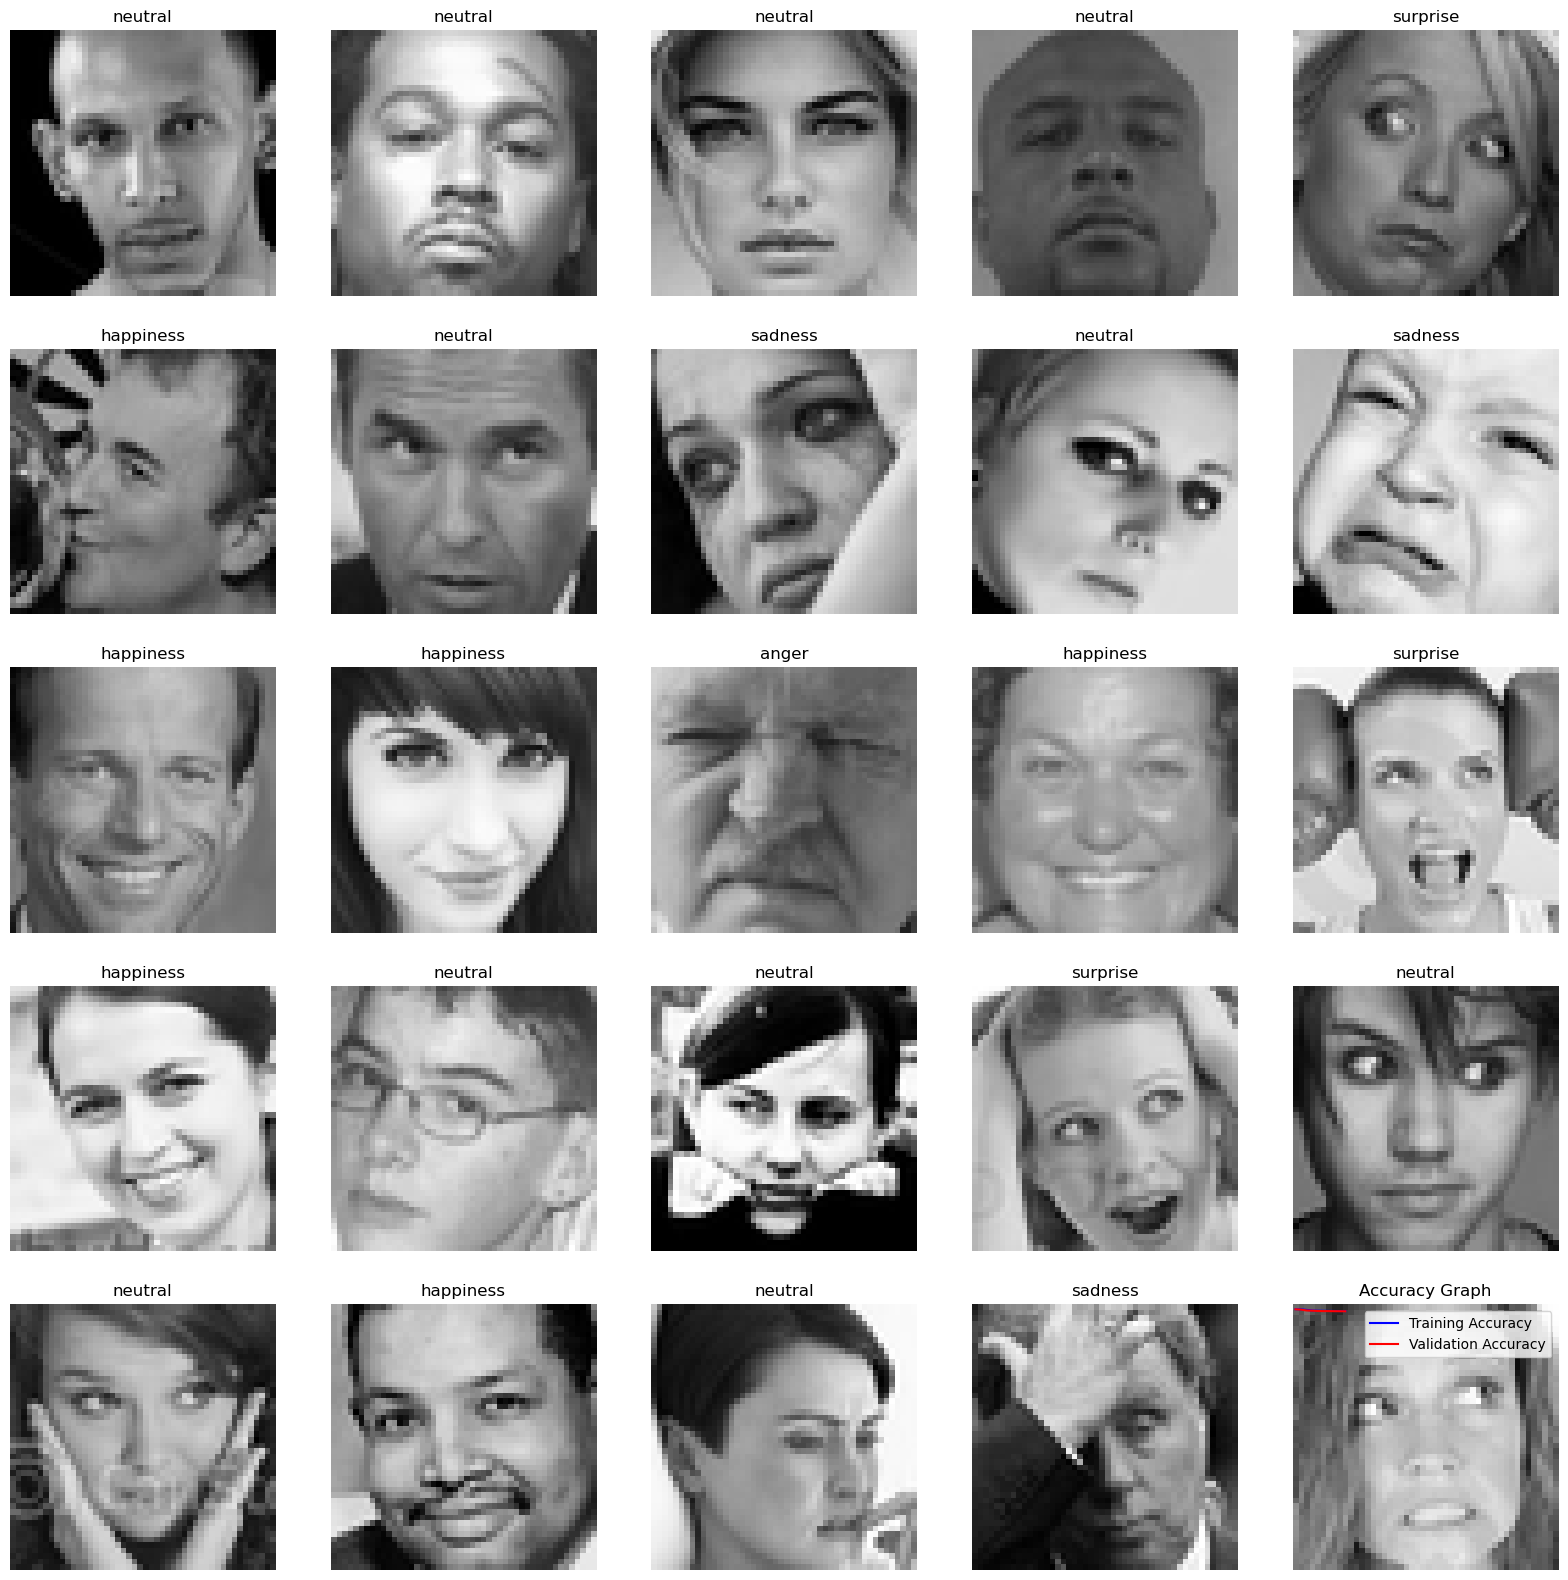

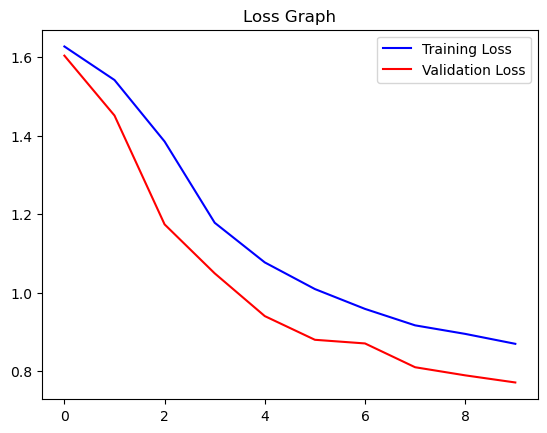

In [20]:
# Evaluate the model on the test set to get the actual accuracy
test_loss, test_accuracy = model.evaluate(x_test, y_test, verbose=0)

# Print the final test accuracy
print(f"Final Test Accuracy: {test_accuracy:.4f}")

# Extract accuracy and loss data from history (during training)
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

# Print epoch-wise training and validation accuracy
print("\nEpoch-wise Training and Validation Accuracy:")
for epoch, (train_acc, valid_acc) in enumerate(zip(acc, val_acc), start=1):
    print(f"Epoch {epoch}: Training Accuracy = {train_acc:.4f}, Validation Accuracy = {valid_acc:.4f}")

# Plot Accuracy Graph
plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

# Plot Loss Graph
plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()


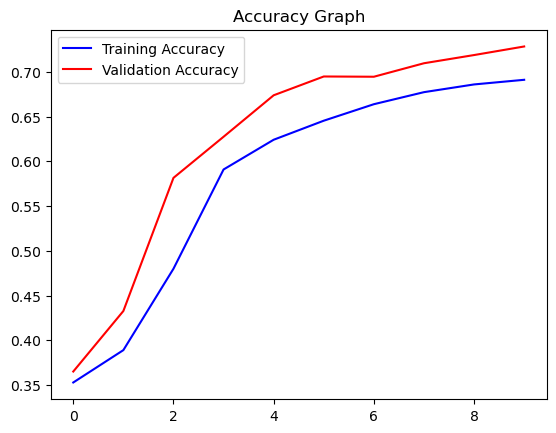

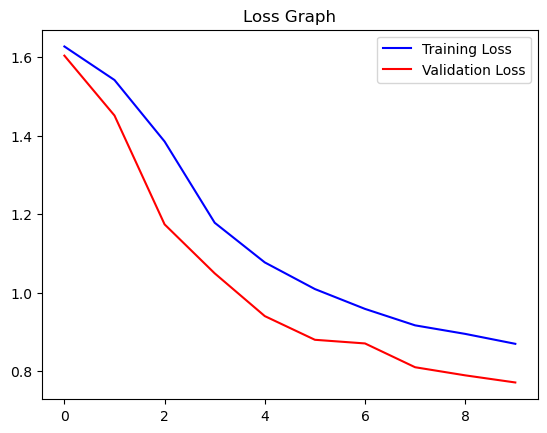

In [21]:
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
epochs = range(len(acc))

plt.plot(epochs, acc, 'b', label='Training Accuracy')
plt.plot(epochs, val_acc, 'r', label='Validation Accuracy')
plt.title('Accuracy Graph')
plt.legend()
plt.figure()

loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(len(acc))

plt.plot(epochs, loss, 'b', label='Training Loss')
plt.plot(epochs, val_loss, 'r', label='Validation Loss')
plt.title('Loss Graph')
plt.legend()

plt.show()

## Test with Image Data

Original Output: disgust
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 81ms/step
Predicted Output: anger


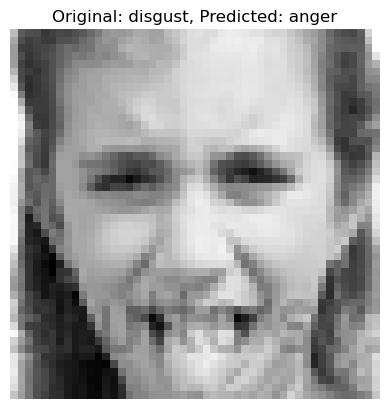

In [32]:
import random
import matplotlib.pyplot as plt


image_index = random.randint(0, len(test) - 1)
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray')
plt.title(f"Original: {test['label'][image_index]}, Predicted: {prediction_label}")
plt.axis('off')
plt.show()


Original Output: neutral
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 82ms/step
Predicted Output: neutral


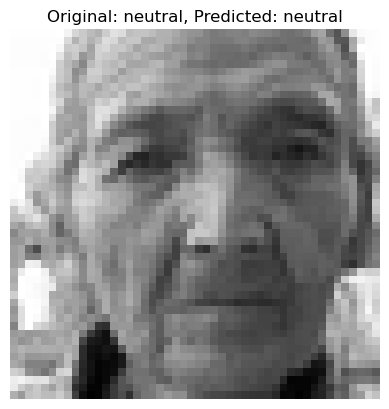

In [33]:
image_index = random.randint(0, len(test) - 1)
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray')
plt.title(f"Original: {test['label'][image_index]}, Predicted: {prediction_label}")
plt.axis('off')
plt.show()


Original Output: sadness
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 84ms/step
Predicted Output: neutral


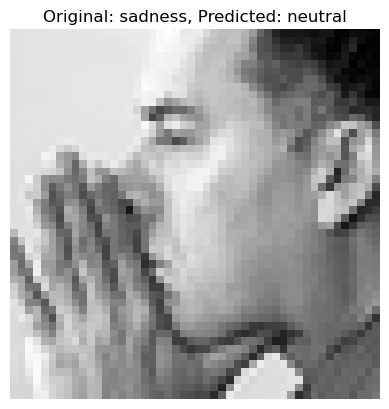

In [34]:
image_index = random.randint(0, len(test) - 1)
print("Original Output:", test['label'][image_index])
pred = model.predict(x_test[image_index].reshape(1, 48, 48, 1))
prediction_label = le.inverse_transform([pred.argmax()])[0]
print("Predicted Output:", prediction_label)
plt.imshow(x_test[image_index].reshape(48, 48), cmap='gray')
plt.title(f"Original: {test['label'][image_index]}, Predicted: {prediction_label}")
plt.axis('off')
plt.show()
